In [3]:
## The code for this was sourced from: https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/tree/master

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [47]:
# Model Hyperparameters

dataset_path = '../data'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 128
img_size = (32, 32) # (width, height)

input_dim = 3
hidden_dim = 512
latent_dim = 64 # I modifierd this from 16 to 32. Lets see if the image quality goes up. 
n_embeddings= 512
output_dim = 3
commitment_beta = 0.25

lr = 2e-4

epochs = 50

print_step = 50

In [48]:
torch.cuda.is_available()

True

###    Step 1. Load (or download) Dataset

In [49]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = CIFAR10(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = CIFAR10(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)

Files already downloaded and verified
Files already downloaded and verified


### Step 2. Define our model: Vector Quantized Variational AutoEncoder (VQ-VAE)

In [50]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=(4, 4, 3, 1), stride=2):
        super(Encoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_size
        
        self.strided_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, stride, padding=1)
        self.strided_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, stride, padding=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_3, padding=1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_4, padding=0)
        
        self.proj = nn.Conv2d(hidden_dim, output_dim, kernel_size=1)
        
    def forward(self, x):
        
        x = self.strided_conv_1(x)
        x = self.strided_conv_2(x)
        
        x = F.relu(x)
        y = self.residual_conv_1(x)
        y = y+x
        
        x = F.relu(y)
        y = self.residual_conv_2(x)
        y = y+x
        
        y = self.proj(y)
        return y

In [51]:
class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        
        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

    def encode(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = (-torch.cdist(x_flat, self.embedding, p=2)) ** 2

        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        return quantized, indices.view(x.size(0), x.size(1))
    
    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)
        
        return quantized

    def forward(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)
        
        distances = (-torch.cdist(x_flat, self.embedding, p=2)) ** 2

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, M).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        
        if self.training:
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
            n = torch.sum(self.ema_count)
            self.ema_count = (self.ema_count + self.epsilon) / (n + M * self.epsilon) * n

            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity

In [52]:
class Decoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_sizes=(1, 3, 2, 2), stride=2):
        super(Decoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes
        
        self.in_proj = nn.Conv2d(input_dim, hidden_dim, kernel_size=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_1, padding=0)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=1)
        
        self.strided_t_conv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_3, stride, padding=0)
        self.strided_t_conv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_4, stride, padding=0)
        
    def forward(self, x):

        x = self.in_proj(x)
        
        y = self.residual_conv_1(x)
        y = y+x
        x = F.relu(y)
        
        y = self.residual_conv_2(x)
        y = y+x
        y = F.relu(y)
        
        y = self.strided_t_conv_1(y)
        y = self.strided_t_conv_2(y)
        
        return y

In [53]:
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
                
    def forward(self, x):
        z = self.encoder(x)
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
        x_hat = self.decoder(z_quantized)
        
        return x_hat, commitment_loss, codebook_loss, perplexity

In [54]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=latent_dim)
codebook = VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=latent_dim)
decoder = Decoder(input_dim=latent_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [55]:
from torch.optim import Adam

mse_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Vector Quantized Variational AutoEncoder (VQ-VAE)

In [56]:
print("Start training VQ-VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        recon_loss = mse_loss(x_hat, x)
        
        loss =  recon_loss + commitment_loss * commitment_beta + codebook_loss
                
        loss.backward()
        optimizer.step()
        
        if batch_idx % print_step ==0: 
            print("epoch:", epoch + 1, "(", batch_idx + 1, ") recon_loss:", recon_loss.item(), " perplexity: ", perplexity.item(), 
              " commit_loss: ", commitment_loss.item(), "\n\t codebook loss: ", codebook_loss.item(), " total_loss: ", loss.item(), "\n")
    
print("Finish!!")

Start training VQ-VAE...
epoch: 1 ( 1 ) recon_loss: 0.2744457721710205  perplexity:  37.37276077270508  commit_loss:  0.0015133004635572433 
	 codebook loss:  0.006053201854228973  total_loss:  0.2808772921562195 

epoch: 1 ( 51 ) recon_loss: 0.041972529143095016  perplexity:  40.452003479003906  commit_loss:  0.0937255471944809 
	 codebook loss:  0.3749021887779236  total_loss:  0.4403060972690582 

epoch: 1 ( 101 ) recon_loss: 0.02841569297015667  perplexity:  103.49205780029297  commit_loss:  0.09141404181718826 
	 codebook loss:  0.36565616726875305  total_loss:  0.4169253706932068 

epoch: 1 ( 151 ) recon_loss: 0.024340417236089706  perplexity:  202.1044158935547  commit_loss:  0.09999854117631912 
	 codebook loss:  0.3999941647052765  total_loss:  0.44933420419692993 

epoch: 1 ( 201 ) recon_loss: 0.020336976274847984  perplexity:  221.8924102783203  commit_loss:  0.08311617374420166 
	 codebook loss:  0.33246469497680664  total_loss:  0.3735807240009308 

epoch: 1 ( 251 ) recon_

epoch: 27 ( 351 ) recon_loss: 0.005845227278769016  perplexity:  427.2381286621094  commit_loss:  0.024677637964487076 
	 codebook loss:  0.0987105518579483  total_loss:  0.11072518676519394 

epoch: 28 ( 1 ) recon_loss: 0.006040177773684263  perplexity:  423.53997802734375  commit_loss:  0.024659644812345505 
	 codebook loss:  0.09863857924938202  total_loss:  0.11084366589784622 

epoch: 28 ( 51 ) recon_loss: 0.005875284783542156  perplexity:  419.6992492675781  commit_loss:  0.02430611290037632 
	 codebook loss:  0.09722445160150528  total_loss:  0.10917626321315765 

epoch: 28 ( 101 ) recon_loss: 0.005523922853171825  perplexity:  418.89190673828125  commit_loss:  0.02324381284415722 
	 codebook loss:  0.09297525137662888  total_loss:  0.10431012511253357 

epoch: 28 ( 151 ) recon_loss: 0.005785196553915739  perplexity:  424.33038330078125  commit_loss:  0.02393510192632675 
	 codebook loss:  0.095740407705307  total_loss:  0.10750938206911087 

epoch: 28 ( 201 ) recon_loss: 0.0052

epoch: 33 ( 101 ) recon_loss: 0.005258515477180481  perplexity:  411.63336181640625  commit_loss:  0.022684425115585327 
	 codebook loss:  0.09073770046234131  total_loss:  0.10166732221841812 

epoch: 33 ( 151 ) recon_loss: 0.005225612781941891  perplexity:  411.553466796875  commit_loss:  0.021602418273687363 
	 codebook loss:  0.08640967309474945  total_loss:  0.09703589230775833 

epoch: 33 ( 201 ) recon_loss: 0.005143664311617613  perplexity:  410.52996826171875  commit_loss:  0.021427415311336517 
	 codebook loss:  0.08570966124534607  total_loss:  0.09621018171310425 

epoch: 33 ( 251 ) recon_loss: 0.005412805825471878  perplexity:  414.43060302734375  commit_loss:  0.022285299375653267 
	 codebook loss:  0.08914119750261307  total_loss:  0.10012532770633698 

epoch: 33 ( 301 ) recon_loss: 0.005836427211761475  perplexity:  427.2894592285156  commit_loss:  0.0234709233045578 
	 codebook loss:  0.0938836932182312  total_loss:  0.10558785498142242 

epoch: 33 ( 351 ) recon_loss: 0

epoch: 38 ( 251 ) recon_loss: 0.005635052919387817  perplexity:  406.9923095703125  commit_loss:  0.02307410165667534 
	 codebook loss:  0.09229640662670135  total_loss:  0.10369998216629028 

epoch: 38 ( 301 ) recon_loss: 0.005197464954108  perplexity:  417.60552978515625  commit_loss:  0.02259363979101181 
	 codebook loss:  0.09037455916404724  total_loss:  0.10122043639421463 

epoch: 38 ( 351 ) recon_loss: 0.005449438467621803  perplexity:  417.0762023925781  commit_loss:  0.023363234475255013 
	 codebook loss:  0.09345293790102005  total_loss:  0.10474318265914917 

epoch: 39 ( 1 ) recon_loss: 0.005047259386628866  perplexity:  405.8835754394531  commit_loss:  0.021579589694738388 
	 codebook loss:  0.08631835877895355  total_loss:  0.09676051139831543 

epoch: 39 ( 51 ) recon_loss: 0.004988676868379116  perplexity:  413.8494567871094  commit_loss:  0.0210050530731678 
	 codebook loss:  0.0840202122926712  total_loss:  0.09426015615463257 

epoch: 39 ( 101 ) recon_loss: 0.00487632

epoch: 44 ( 1 ) recon_loss: 0.005365549586713314  perplexity:  420.2828369140625  commit_loss:  0.02318747341632843 
	 codebook loss:  0.09274989366531372  total_loss:  0.10391230881214142 

epoch: 44 ( 51 ) recon_loss: 0.005332503467798233  perplexity:  429.44525146484375  commit_loss:  0.02359164133667946 
	 codebook loss:  0.09436656534671783  total_loss:  0.10559698194265366 

epoch: 44 ( 101 ) recon_loss: 0.0045990655198693275  perplexity:  398.83026123046875  commit_loss:  0.019981564953923225 
	 codebook loss:  0.0799262598156929  total_loss:  0.08952071517705917 

epoch: 44 ( 151 ) recon_loss: 0.00534474803134799  perplexity:  423.6898498535156  commit_loss:  0.023101825267076492 
	 codebook loss:  0.09240730106830597  total_loss:  0.1035275012254715 

epoch: 44 ( 201 ) recon_loss: 0.004707690328359604  perplexity:  391.2161560058594  commit_loss:  0.020049063488841057 
	 codebook loss:  0.08019625395536423  total_loss:  0.08991621434688568 

epoch: 44 ( 251 ) recon_loss: 0.004

epoch: 49 ( 151 ) recon_loss: 0.005134007893502712  perplexity:  413.6485900878906  commit_loss:  0.021591655910015106 
	 codebook loss:  0.08636662364006042  total_loss:  0.09689854830503464 

epoch: 49 ( 201 ) recon_loss: 0.005293588619679213  perplexity:  427.2896728515625  commit_loss:  0.02170651964843273 
	 codebook loss:  0.08682607859373093  total_loss:  0.0975462943315506 

epoch: 49 ( 251 ) recon_loss: 0.005146482028067112  perplexity:  411.0490417480469  commit_loss:  0.02182190865278244 
	 codebook loss:  0.08728763461112976  total_loss:  0.09788959473371506 

epoch: 49 ( 301 ) recon_loss: 0.004939499776810408  perplexity:  414.39959716796875  commit_loss:  0.020826108753681183 
	 codebook loss:  0.08330443501472473  total_loss:  0.09345046430826187 

epoch: 49 ( 351 ) recon_loss: 0.004917894955724478  perplexity:  422.0533447265625  commit_loss:  0.02228834480047226 
	 codebook loss:  0.08915337920188904  total_loss:  0.09964336454868317 

epoch: 50 ( 1 ) recon_loss: 0.005

### Step 5. Evaluate the model

In [57]:
import matplotlib.pyplot as plt

In [58]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

In [59]:
model.eval()

with torch.no_grad():

    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):

        x = x.to(DEVICE)
        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
 
        print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
        break

  0%|          | 0/79 [00:00<?, ?it/s]

perplexity:  449.0038146972656 commit_loss:  0.06631691753864288   codebook loss:  0.26526767015457153


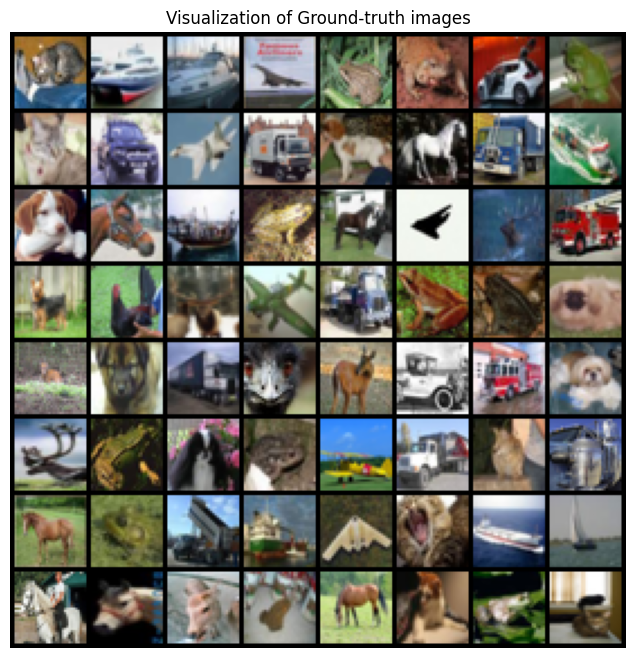

In [60]:
draw_sample_image(x[:batch_size//2], "Ground-truth images")

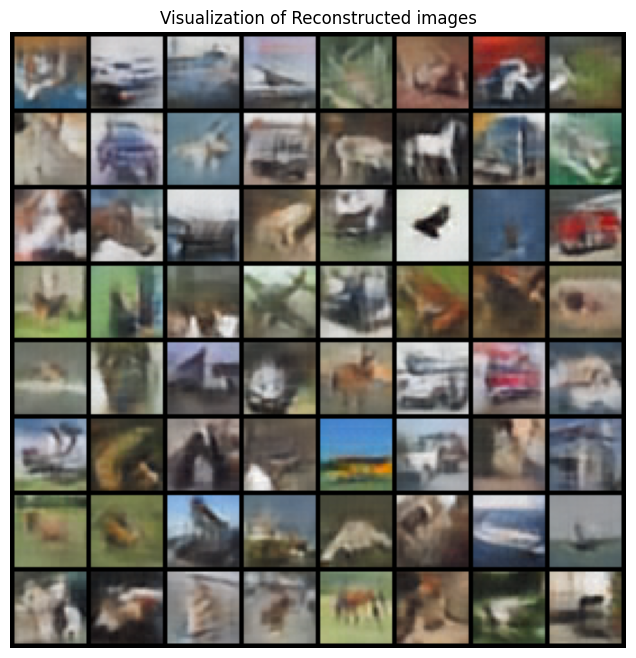

In [61]:
draw_sample_image(x_hat[:batch_size//2], "Reconstructed images")

### Step 6. Generate samples via random codes

In [62]:
def draw_random_sample_image(codebook, decoder, indices_shape):
    
    random_indices = torch.floor(torch.rand(indices_shape) * n_embeddings).long().to(DEVICE)
    codes = codebook.retrieve_random_codebook(random_indices)
    x_hat = decoder(codes.to(DEVICE))
    
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of Random Codes")
    plt.imshow(np.transpose(make_grid(x_hat.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

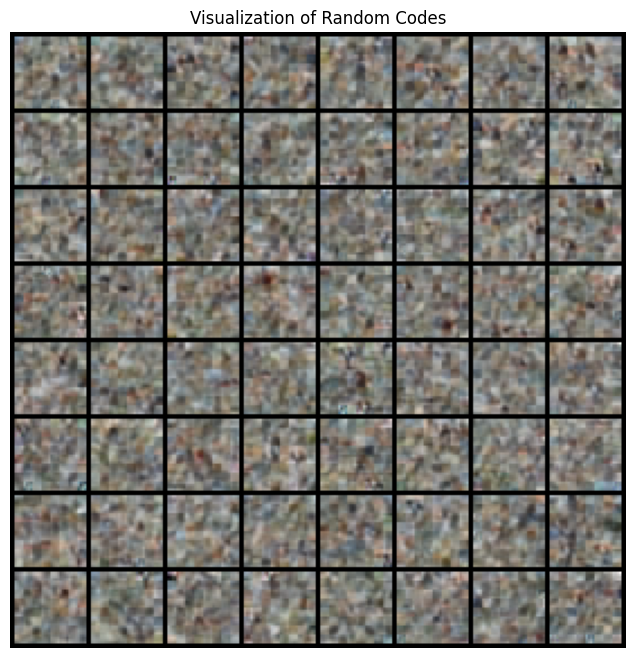

In [63]:
draw_random_sample_image(codebook, decoder, indices_shape=(batch_size//2, 8, 8))

## STUFF THATS NOT NECESSARY 

In [64]:
!nvidia-smi

Sat Nov 30 22:35:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-16GB           On  |   00000000:18:00.0 Off |                    0 |
| N/A   44C    P0             44W /  300W |       1MiB /  16384MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [65]:
ls

01_Variational_AutoEncoder.ipynb                   tmp.wav
02_Vector_Quantized_Variational_AutoEncoder.ipynb  tmp2.wav
Data_Exploration_Aquila.ipynb                      tmp3.wav
Lakh_Statistics_Bootes.ipynb                       tmp4.wav
Using_AMT_Carina.ipynb                             tmp5.wav
anticipation/                                      tmp6.wav
fluidsynth.raw                                     transfomers.ipynb
tmp.mid


In [69]:
ls

01_Variational_AutoEncoder.ipynb                   tmp.wav
02_Vector_Quantized_Variational_AutoEncoder.ipynb  tmp2.wav
Data_Exploration_Aquila.ipynb                      tmp3.wav
Lakh_Statistics_Bootes.ipynb                       tmp4.wav
Using_AMT_Carina.ipynb                             tmp5.wav
anticipation/                                      tmp6.wav
fluidsynth.raw                                     transfomers.ipynb
tmp.mid
